<a href="https://colab.research.google.com/github/pena-rodrigo/golombCA1/blob/main/Golomb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Created on Mar 2 2022
"""

import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "DejaVu Sans"
import pandas as pd
import time
from scipy import signal
from scipy import stats
from scipy.ndimage import gaussian_filter
import seaborn as sns
import random
import pylab
pylab.rcParams['savefig.dpi'] = 120
#matplotlib inline

In [2]:
""" Parameters simulation """
dt = 0.01# 0.05, OLM only works for 0.01
tf = 800
N = round(tf/dt)
D = 0.1

In [3]:
"""stim functions"""

Ipoisson = lambda r: 1*(np.random.rand()<r*10**-3*dt)
Izap = lambda i, Fzap, A: A*np.sin(2*np.pi*Fzap*10**-3*i*dt + 3*np.pi/2)

def rect(T):
    """create a centered rectangular pulse of width $T"""
    return lambda t: (-T/2 <= t) & (t < T/2)

def pulse_train(t, at, shape):
    """create a train of pulses over $t at times $at and shape $shape"""
    return np.sum(shape(t - at[:,np.newaxis]), axis=0)

In [4]:
class HHca:
    """Golomb model with Ca"""
    nid=0 #default neuron id
    sendspk=0
    
    C = 1
    Gl=0.05
    Vl = -70
    Gna = 35
    Gnap = 0.3 #varies between 0 and 0.41 mS/cm2
    thetam = -30
    deltam = 9.5
    Vna = 55
    Gkdr = 6
    thetah = -45
    deltah = -7
    thetaht= -40.5
    deltaht= -6
    Vk = -90
    thetap = -47 #-47#-41 #varies between -47mV and -41mV
    deltap = 3
    thetan = -35
    deltan = 10
    thetant =-27
    deltant=-15
    Ga = 1.4
    thetaa = -50
    deltaa = 20
    taub = 15
    thetab = -80
    deltab = -6
    Gm = 1
    tauz = 75
    thetaz = -39
    deltaz = 5
    
    Gca = 0.#0*0.2 #varies between 0 and 0.2 mS/cm2
    Gc = 10
    Gsahp = 5
    Vca = 120
    thetar=-20
    deltar=10
    taur=1
    thetac=-30
    deltac=7
    tauc=2
    ac=6
    tauq=450
    aq=2
    
    nu=0.13
    tauca=13
    
    Iapp = 0
    
    D = 0.0   
    
    Ein=-80.
    Eex=0.
    Gie=0.08
    Goe=0.08#0.15
    tauR_ampa = 0.1
    tauD_ampa = 3.0
    tauR_gaba = 0.2
    tauD_gaba = 20.

    vth=0

    countdelay=0
    
    spktimes = []

    
    def __init__(self,nid=1,D=0.1,Gnap=0.3,Ca_acum=0.0001, No = 1.0, Ni=1.0):
        self.Gie = self.Gie/Ni
        self.Goe = self.Goe/No
        self.minf= lambda V:  1.0/(1+np.exp(-(V-self.thetam)/self.deltam))
        self.hinf= lambda V:  1.0/(1+np.exp(-(V-self.thetah)/self.deltah))
        self.tauh= lambda V:  0.1 + 0.75*(1.0/(1+np.exp(-(V-self.thetaht)/self.deltaht)))
        self.ninf= lambda V:  1.0/(1+np.exp(-(V-self.thetan)/self.deltan))
        self.taun= lambda V:  0.1 + 0.5*(1.0/(1+np.exp(-(V-self.thetant)/self.deltant)))
        self.pinf= lambda V:  1.0/(1+np.exp(-(V-self.thetap)/self.deltap))
        self.ainf= lambda V:  1.0/(1+np.exp(-(V-self.thetaa)/self.deltaa))
        self.binf= lambda V:  1.0/(1+np.exp(-(V-self.thetab)/self.deltab))
        self.zinf= lambda V:  1.0/(1+np.exp(-(V-self.thetaz)/self.deltaz))
        
        self.rinf= lambda V:  1.0/(1+np.exp(-(V-self.thetar)/self.deltar))
        self.cinf= lambda V:  1.0/(1+np.exp(-(V-self.thetac)/self.deltac))
        self.dinf= lambda Ca_acum:  1.0/(1+self.ac/Ca_acum)
        self.qinf= lambda Ca_acum:  1.0/(1+(self.aq**4)/(Ca_acum**4))

        self.Nv = lambda V: ( 1+np.tanh(V/4.0) )#/2.
        
        self.nid = nid
        self.D = D      
        self.v = -72.#-89.09
        self.h = 0
        self.n = 0
        self.b = 0
        self.z = 0       
        self.s = 0
        self.sie=0
        self.soe=0
        self.r=0
        self.c=0
        self.Ca_acum=Ca_acum #0.1#1.2#2.0
        self.Gnap=Gnap
        self.q=0
        self.spktimes = []
        
    def _UpdateKs(self,v,h,n,b,z,r,c,Ca_acum,q,s,stim):
        Isyn = self.Gie*self.sie*(v-self.Ein) + self.Goe*self.soe*(v-self.Ein)
          
        Il = self.Gl * (v - self.Vl)
        Ina  = self.Gna * (self.minf(v)**3) * h *(v-self.Vna)
        Inap = self.Gnap * self.pinf(v) * (v-self.Vna)
        Ikdr = self.Gkdr * (n**4) * (v-self.Vk) 
        IA   = self.Ga * (self.ainf(v)**3) * b * (v-self.Vk)
        IM   = self.Gm * z * (v-self.Vk)
        
        Ica  = self.Gca * (r**2) * (v-self.Vca) 
        Ic   = self.Gc * self.dinf(Ca_acum) * c * (v-self.Vk)
        Isahp= self.Gsahp * q * (v-self.Vk)
        
        Itotal =  self.Iapp - Il - Ina - Inap - Ikdr - IA - IM - Ica - Ic - Isahp + stim - Isyn
        
        kv = Itotal / (self.C)
        kh = (self.hinf(v)-h)/self.tauh(v)
        kn = (self.ninf(v)-n)/self.taun(v)
        kb = (self.binf(v)-b)/self.taub
        kz = (self.zinf(v)-z)/self.tauz     
        
        kr = (self.rinf(v)-r)/self.taur  
        kc = (self.cinf(v)-c)/self.tauc
        kCa_acum = -self.nu*Ica - Ca_acum/self.tauca
        kq = (self.qinf(Ca_acum)-q)/self.tauq
        
        ks = self.Nv(v)*(1-s)/self.tauR_ampa - s/self.tauD_ampa

        return kv, kh, kn, kb, kz, kr, kc, kCa_acum, kq, ks

    def _Updatev(self,stim,sie,soe,dt,time):
        self.sie = sie
        self.soe = soe
        if(self.countdelay>0):
            self.countdelay-=dt
        if(self.countdelay<0):
            self.countdelay=0
            self.s += 1
  
        k1v, k1h, k1n, k1b, k1z, k1r, k1c, k1Ca_acum, k1q, k1s = self._UpdateKs(self.v,self.h,self.n,self.b,self.z,self.r,self.c,self.Ca_acum,self.q,self.s,stim)
        a_v= self.v + k1v*dt/2
        a_h= self.h + k1h*dt/2
        a_n= self.n + k1n*dt/2
        a_b= self.b + k1b*dt/2
        a_z= self.z + k1z*dt/2
        a_r= self.r + k1r*dt/2
        a_c= self.c + k1c*dt/2
        a_Ca_acum= self.Ca_acum + k1Ca_acum*dt/2
        a_q= self.q + k1q*dt/2
        a_s= self.s + k1s*dt/2
        
        k2v, k2h, k2n, k2b, k2z, k2r, k2c, k2Ca_acum, k2q, k2s = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,stim)
        a_v= self.v + k2v*dt/2
        a_h= self.h + k2h*dt/2
        a_n= self.n + k2n*dt/2
        a_b= self.b + k2b*dt/2
        a_z= self.z + k2z*dt/2
        a_r= self.r + k2r*dt/2
        a_c= self.c + k2c*dt/2
        a_Ca_acum= self.Ca_acum + k2Ca_acum*dt/2
        a_q= self.q + k2q*dt/2
        a_s= self.s + k2s*dt/2
        
        k3v, k3h, k3n, k3b, k3z, k3r, k3c, k3Ca_acum, k3q, k3s = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,stim)
        a_v= self.v + k3v*dt
        a_h= self.h + k3h*dt
        a_n= self.n + k3n*dt
        a_b= self.b + k3b*dt
        a_z= self.z + k3z*dt
        a_r= self.r + k3r*dt
        a_c= self.c + k3c*dt
        a_Ca_acum= self.Ca_acum + k3Ca_acum*dt
        a_q= self.q + k3q*dt
        a_s= self.s + k3s*dt
        
        k4v, k4h, k4n, k4b, k4z, k4r, k4c, k4Ca_acum, k4q, k4s = self._UpdateKs(a_v,a_h,a_n,a_b,a_z,a_r,a_c,a_Ca_acum,a_q,a_s,stim)
        self.v += dt*(k1v+2*k2v+2*k3v+k4v)/6 + np.random.randn()*np.sqrt(2*self.D*dt)
        self.h += dt*(k1h+2*k2h+2*k3h+k4h)/6
        self.n += dt*(k1n+2*k2n+2*k3n+k4n)/6
        self.b += dt*(k1b+2*k2b+2*k3b+k4b)/6
        self.z += dt*(k1z+2*k2z+2*k3z+k4z)/6
        self.r += dt*(k1r+2*k2r+2*k3r+k4r)/6
        self.c += dt*(k1c+2*k2c+2*k3c+k4c)/6
        self.Ca_acum += dt*(k1Ca_acum+2*k2Ca_acum+2*k3Ca_acum+k4Ca_acum)/6
        self.q += dt*(k1q+2*k2q+2*k3q+k4q)/6
        self.s += dt*(k1s+2*k2s+2*k3s+k4s)/6

        self.sendspk=0
        if(self.v>self.vth):
            self.spktimes.append(time)
            self.sendspk=1
            
    def add_pre_spike(self,delay):
        self.countdelay = delay 
        self.sendspk=0
        
    def delay_count(self,delay):
        self.countdelay = delay 
        
    def add_external(self):
        self.sext += 1
        
    def eval(self,stim,sie,soe,dt,time):
        self._Updatev(stim,sie,soe,dt,time)

simulation time
22.167662620544434
simulation time
22.241077661514282
simulation time
21.048234462738037
simulation time
22.311331272125244


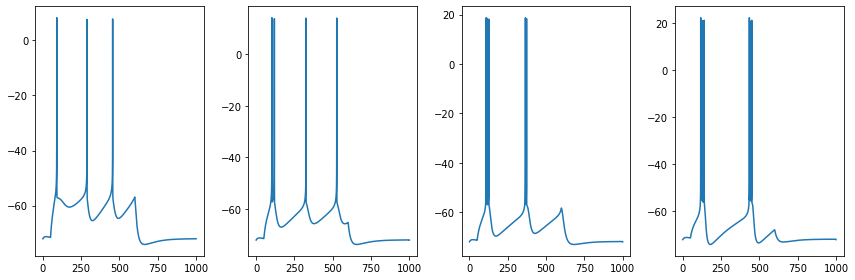

In [10]:
"""test neuron
   Fig 6b of Golomb et al paper
"""
dt = 0.01
tf = 1000

strong = 0.05
Iapp=[0.84+strong, 0.59+strong, 0.46+strong ,0.36+strong] # Iapp
gNaP=[0.0, 0.08, 0.18, 0.3] # gNaP

plt.figure(figsize=(12,4))
for j in range(4):

  v = np.empty(N)
  neuron = HHca(D=0.,Gnap=gNaP[j])
   
  start = time.time()  
  for i in np.arange(0,round(tf/dt))-1:
      if(i*dt<50 or i*dt>600):
        neuron.eval(0.0,0,0,dt,i*dt)
      else:
        neuron.eval(Iapp[j],0,0,dt,i*dt)
      v[i] = neuron.v

  end = time.time() 
  print('simulation time')
  print(end - start)  

  t = np.arange(0,tf,dt)
  plt.subplot(1,4,j+1)
  plt.plot(t,v)
# plt.xlim([90,150])
plt.tight_layout()
plt.show()